<div style="text-align: center;"><br>
<img src="https://assets-global.website-files.com/62b9d45fb3f64842a96c9686/62d84db4aeb2f6552f3a2f78_Quantinuum%20Logo__horizontal%20blue.svg" width="200" height="200" /></div>

# H-Series Emulators

Quantinuum provides an emulator equivalents to all their devices (**H2-1**), denoted by a suffix **E** or **LE** trailing the device name (**H2-1E** or **H2-1LE**). Emulators are used in conjunction with syntax checkers to debug and optimize jobs before submission to the real device. Emulators differ from simulators in that they *emulate* the device's characteristics, whereas simulators only model noise parameters. The Quantinuum emulators apply a physical noise model of the Quantinuum H-Series devices.

* **State-vector Emulator**: The default mode of the emulator. The circuit must satisfy the gate-set predicate. The emulator will compute the state-vector of the circuit and estimate the measurement distribution from that state-vector.
* **Stabilizer Emulator:** Use of the emulator for circuits involving only Clifford operations.
* **Noiseless Emulation:** Disable the noise model for state-vector and stabilizer emulators. Only shot noise is present in the emulation result. The **pytket-pecos** package enables noiseless emulation locally.
* **Noise Model Customization:** Experiment with the noise parameters in the emulator. There is no guarantee that results achieved changing these parameters will represent outputs from the actual quantum computer represented.

**Contents:**
* [Basic-Usage](#Basic-Usage)
* [Availability & Usage of Emulators](#Availability-and-Usage-of-Emulators)
* [State-vector & Stabilizer Emulator](#State-vector-&-Stabilizer-Emulator)
* [Noiseless Emulation](#Noiseless-Emulation)
* [Noise Model Customization](#Noise-Model-Customization)
* [Use-Case: Noise-Model Analysis](#Use-Case:-Noise-Model-Analysis)

## Basic-Usage

In the code-cell below, QuantinuumBackend is constructed with the `device_name` argument specified as the H1-1 emulator (`H1-1E`). The QuantinuumBackend instance will be used to:
* **Compile** the circuit to satisfy the gate-set predicate for the emulator using the instance `get_compiled_circuit` method.
* **Cost** the circuit to identify HQC consumption for emulation using the instance `cost` method.
* **Submit** the circuit for emulation via `process_circuit`.
* **Check job status** for the submitted circuit with `circuit_status`.
* **Retrieve** job result after emulation with `get_result`.

These actions are identical for both QPU (Quantum Processing Unit) usage and emulator usage.

In [1]:
from pytket.extensions.quantinuum import QuantinuumBackend

backend = QuantinuumBackend("H1-1E")
backend.login()

The 4-qubit circuit contains the following features:
* Native arbitrary-angle two-qubit gate (`OpType.ZZPhase`).
* Native arbitrary-angle one-qubit gate (`OpType.PhasedX`).
* MCMR (mid-circuit measurement with reset).
* Classically-controlled `OpType.X` operation.

In [2]:
from pytket.circuit import Circuit
from pytket.circuit.display import render_circuit_jupyter

circuit = Circuit(4, 1)
for i, j in zip(circuit.qubits[:-1], circuit.qubits[1:]):
    circuit.ZZPhase(0.1, i, j)

# Add MCMR
circuit.Measure(circuit.qubits[-1], circuit.bits[0])
circuit.Reset(circuit.qubits[-1])
circuit.X(circuit.qubits[-1], condition=circuit.bits[0])


for i, j in zip(circuit.qubits[:-1], circuit.qubits[1:]):
    circuit.ZZPhase(0.1, i, j)
for i in circuit.qubits:
    circuit.PhasedX(0.06, -0.09, i)

## Add Final Measurement
circuit.measure_all()

render_circuit_jupyter(circuit)

Compiling the circuit with `QuantinuumBackend`, replaces the classically-controlled `OpType.X` operation with an `OpType.Phase` node and a classically-controlled `Optype.PhasedX`.

In [3]:
compiled_circuit = backend.get_compiled_circuit(circuit, optimisation_level=2)

render_circuit_jupyter(compiled_circuit)

The compiled circuit can be submitted to the `H1-1SC`, to estimate HQC consumption for emulation, via the `cost` function.

In [4]:
hqc_cost = backend.cost(compiled_circuit, n_shots=100, syntax_checker="H1-1SC")
print(hqc_cost)

7.46


`process_circuit` is used to submit the compiled circuit for emulation.

In [5]:
handle = backend.process_circuit(compiled_circuit, n_shots=100)

The `ResultHandle` object, a reference to the job submitted to the H-Series emulator, is saved to disk with `json`.

In [6]:
import json

with open("result_handle.json", "w") as json_io:
    json.dump([str(handle)], json_io)

The `ResultHandle` data is loaded from disk and used to instantiate a `ResultHandle` object.

In [7]:
from pytket.backends.resulthandle import ResultHandle

with open("result_handle.json", "r") as json_io:
    result_handle_str_list = json.load(json_io)
    handle = ResultHandle.from_str(result_handle_str_list[0])

The `ResultHandle` object is used to query the status of the job submitted to the H-Series emulator.

In [8]:
job_status = backend.circuit_status(handle)
print(job_status)

CircuitStatus(status=<StatusEnum.QUEUED: 'Circuit is queued.'>, message='{"name": "job", "submit-date": "2024-04-02T15:12:46.676648", "result-date": null, "queue-position": null, "cost": "7.46", "error": null}', error_detail=None, completed_time=None, queued_time=None, submitted_time=None, running_time=None, cancelled_time=None, error_time=None, queue_position=None)


`get_result` can be used to retrieve the job result after H-Series emulation is complete.

In [9]:
result = backend.get_result(handle)

## Availability & Usage of Emulators

All H-Series devices have a <span style="color:red">cloud emulators</span> (suffix `E`) and a <span style="color:green">local emulators</span> (suffix `LE`).

Users can access <span style="color:red">cloud emulators</span> with their Quantinuum credentials over the cloud. These emulators are hosted on Quantinuum infrastructure, consume HQCs upon usage and are available 247. To use these remote emulators, the user must submit jobs to a Fair-Share queue. Remote emulators replicate H-Series device and noise characteristics. The noise model on the emulator can be configured using the Quantinuum API. User can also access <span style="color:green">local emulators</span>. Local emulators do not consume HQCs and only provide noiseless emulation. The user does not need to submit jobs to a queue. For smaller noiseless emulations involving less than 16-qubits, it is recommended to use the local emulators. For larger emulations, or emulations using a noise model, cloud emulation is recommended.

* <span style="color:red">H1-1E</span>
* <span style="color:green">H1-1LE</span>
* <span style="color:red">H2-1E</span>
* <span style="color:green">H2-1LE</span>

All emulators provide the following features:
* Usage of arbitrary-angle two-qubit gates as well as other native H-Series gates;
* All-to-all connectivity;
* Mid-circuit measurements with reset;
* Identical number of qubits to the corresponding device. `H2-1E` and `H2-1LE` both have 32-qubits maximum.

Remote emulators provide the following features:
* Job Batching (run all jobs by a user in succession);
* A noise-model replicating device noise characteristics.

Remote emulators can only be access via a fair-share queue. Queue-time is dependent on HQC accumulation and user- and group-priorities within their organization. Emulator run-time is dependent on the number of qubits and number of operations in the job. Noisy emulations are slower than noiseless emulations.

Jobs submitted to the remote emulator with a high shot-count are automatically *chunked* into multiple partitions with fewer shot-counts. This enables a more incremental distribution of emulator resources.

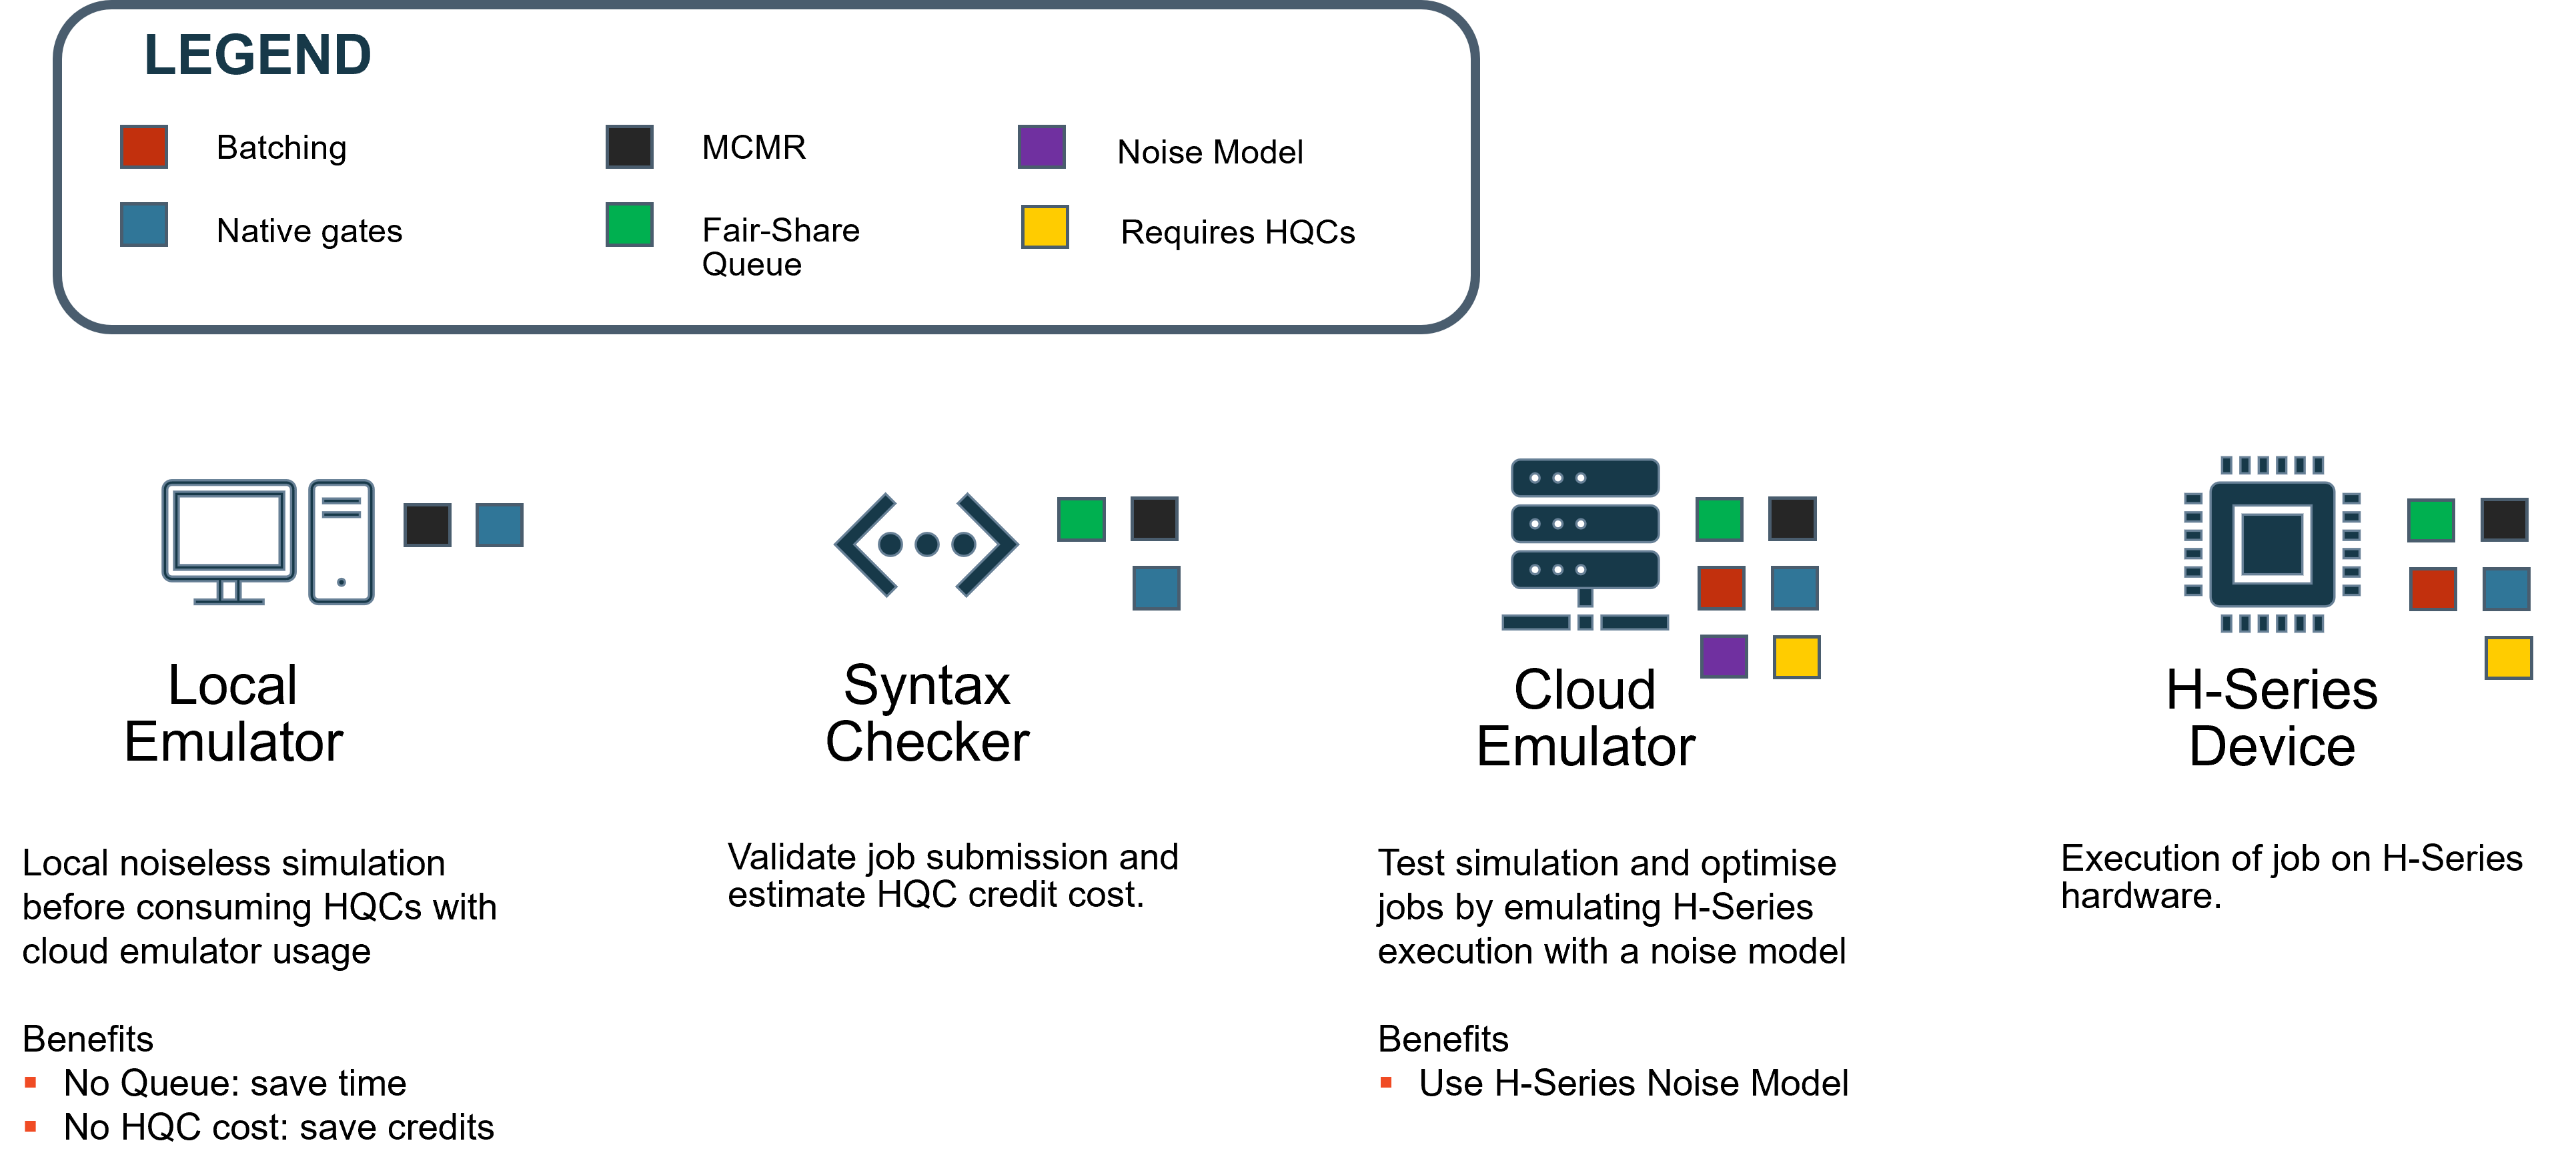

To use the emulator, `QuantinuumBackend` must be constructed using the emulator as the `device_name`.

In [10]:
from pytket.extensions.quantinuum import QuantinuumBackend

backend = QuantinuumBackend(device_name="H1-1E")
backend.login()

All the devices are visible through the `QuantinuumBackend.available_devices` method. 

In [11]:
backend.available_devices()

[BackendInfo(name='QuantinuumBackend', device_name='H1-1SC', version='0.30.0', architecture=<tket::FullyConnected, nodes=20>, gate_set={<OpType.Reset: 65>, <OpType.Rz: 36>, <OpType.PhasedX: 68>, <OpType.ZZMax: 70>, <OpType.Barrier: 8>, <OpType.ClassicalExpBox: 104>, <OpType.ZZPhase: 73>, <OpType.TK2: 41>, <OpType.WASM: 14>, <OpType.SetBits: 15>, <OpType.CopyBits: 16>, <OpType.RangePredicate: 17>, <OpType.ExplicitPredicate: 18>, <OpType.ExplicitModifier: 19>, <OpType.MultiBit: 20>, <OpType.Measure: 63>}, n_cl_reg=120, supports_fast_feedforward=True, supports_reset=True, supports_midcircuit_measurement=True, all_node_gate_errors=None, all_edge_gate_errors=None, all_readout_errors=None, averaged_node_gate_errors=None, averaged_edge_gate_errors=None, averaged_readout_errors=None, misc={'n_shots': 10000, 'system_type': 'syntax checker', 'wasm': True, 'cl_reg_width': 32}),
 BackendInfo(name='QuantinuumBackend', device_name='H1-1E', version='0.30.0', architecture=<tket::FullyConnected, nodes=

These following options can only be used when using the remote H-Series emulators (ending with **E** and not **LE**)

There are two types of simulation method, `state-vector` and `stabilizer`. These can be specified during construction of `QuantinuumBackend` via the `simulator` keyword argument. The default value is `state-vector`.

The Quantinuum API options can also be specified with `QuantinuumBackend` to control if the H-Series noise model is enabled and to configure the parameters within the noise model. They must be specified as a python dictionary and passed to the `options` keyword argument when instantiating QuantinuumBackend.
* `error-model`: A boolean to specify if the error-model should be enabled (True) or disabled (False). By default the error-model is enabled.
* `error-params`: If the error-model is enabled. A nested dictionary is provided containing the error model parameters to tweak.

In [12]:
options = {"error-model": True, "error-params": {"quadratic_dephasing_rate": 0.1}}

qntm_backend_custom = QuantinuumBackend(
    device_name="H2-1E", options=options, simulator="state-vector"
)

The instance method `process_circuit` (`process_circuits`) with the keyword argument `options` can also be used to pass the error model options to the Quantinuum API.

## State-vector & Stabilizer Emulator

Quantinuum provides two emulators, `state-vector` and `stabilizer`.

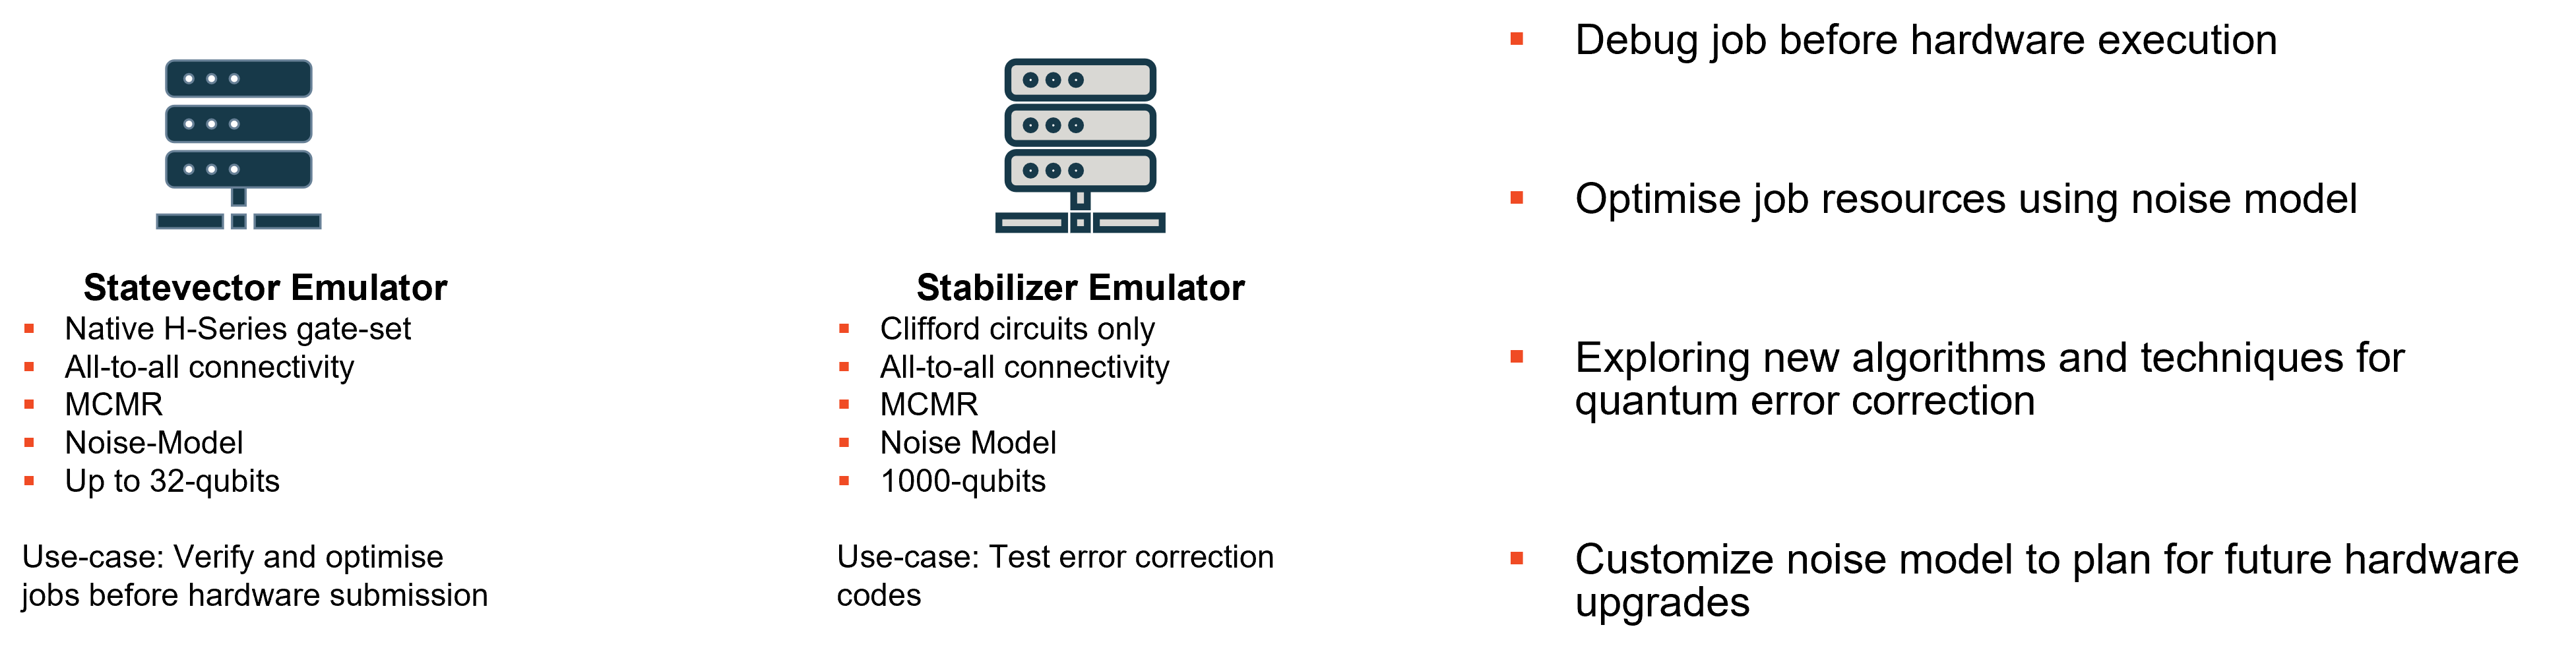
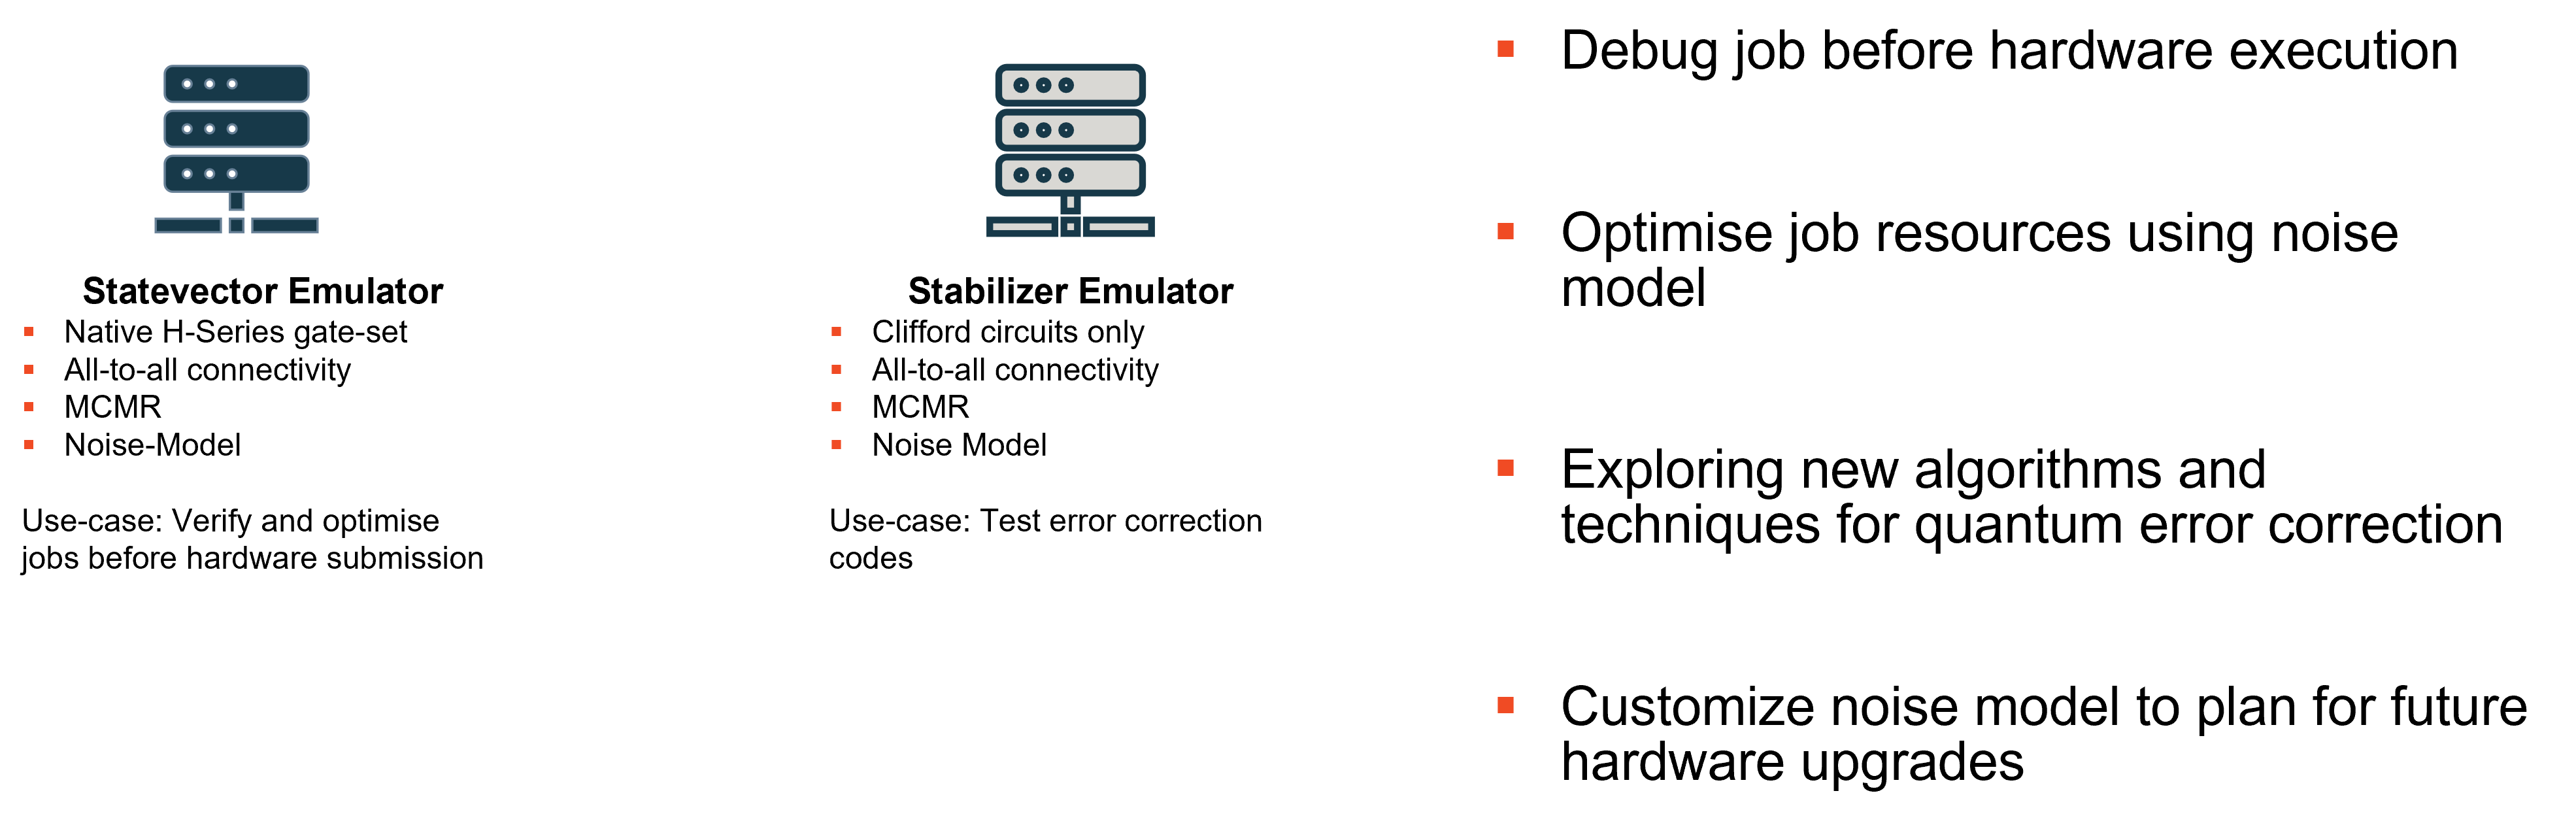

By default, emulations are run using a `state-vector` emulator, which simulates any quantum operation. Provided the input circuit submitted has been compiled to the H-Series native gate-set.

In [13]:
machine = "H1-1E"

If the quantum operations are all Clifford gates, it can be faster for complex circuits to use the `stabilizer` emulator. The stabilizer emulator is requested in the setup of the `QuantinuumBackend` with the `simulator` input option. This option can only be used with H-Series emulators.

In [14]:
stabilizer_backend = QuantinuumBackend(device_name=machine, simulator="stabilizer")

In [15]:
print(machine, "status:", stabilizer_backend.device_state(device_name=machine))
print("Simulation type:", stabilizer_backend.simulator_type)

H1-1E status: online
Simulation type: stabilizer


In [16]:
backend.get_compiled_circuit(Circuit(2).CX(0, 1), optimisation_level=2)

[PhasedX(0.5, 0.5) q[1]; ZZPhase(0.5) q[0], q[1]; Rz(0.5) q[0]; PhasedX(0.5, 0) q[1]; Rz(1.5) q[1]; ]

## Noiseless Emulation

### Enabling and Disabling the Error-Model on QuantinuumBackend

The Quantinuum emulators may be run with or without the physical device's noise model. The default is the emulator runs with the physical noise model turned on. The physical noise model can be turned off by setting `noisy_simulation=False`. Noiseless simulation can be used with both `state-vector` and `stabilizer` emulator.

In [17]:
from pytket.circuit import Circuit

circuit = Circuit(4)
for _ in range(2):
    for i in circuit.qubits:
        circuit.PhasedX(-0.1, -0.2, i)
circuit.measure_all()

compiled_circuit = backend.get_compiled_circuit(circuit)

In [18]:
n_shots = 100
no_error_model_handle = backend.process_circuit(
    compiled_circuit, n_shots=n_shots, noisy_simulation=False
)

An alternative setup is to specify the Quantinuum API option, `error-model` as False, during construction of `QuantinuumBackend`. The `process_circuit` method can be used without using the keyword argument `noisy_simulation`.

In [19]:
backend_noiseless = QuantinuumBackend(
    device_name="H1-1E", options={"error-model": "False"}
)

### Local Emulation using pytket-pecos

To use the local emulators, pytket-quantinuum needs to be installed using the extra install argument `pecos`. All local emulators are state-vector simulators.

Installation command: `pip install pytket-quantinuum[pecos]`.

This provides local emulator targets. Each device has a corresponding local emulator, with the suffix **LE** added to the device name.
* H1-1LE
* H2-1LE

After installation, the end-user can verify the local emulators are usable with the method `have_pecos` with boolean output.

In [20]:
from pytket.extensions.quantinuum import have_pecos

have_pecos()

True

The methods, `process_circuit` and `process_circuits`, provide a keyword argument, `mulithreading` to accelerate local emulation. This can be toggled True to use.

In [21]:
qntm_backend_le = QuantinuumBackend(device_name="H1-1LE")
handle = qntm_backend_le.process_circuit(
    compiled_circuit, n_shots=100, multithreading=True
)

## Noise Model Customization

The emulator runs with default error parameters that represent a noise environment similar to the physical devices. The `error-params` option can be used to customize the noise model. This can be supplied either to: 
* the `QuantinuumBackend` constructor with keyword argument `options`
* the `process_circuit` or `process_circuits` method with the keyword argument `options`.

In [22]:
backend = QuantinuumBackend(device_name="H1-1E", options={"error-params": {"p1": 1e-5}})

handle = backend.process_circuit(
    compiled_circuit, n_shots=10, options={"error-params": {"p2": 1e-4}}
)

### Physical Noise

* **p1:** Probability of a fault during a single-qubit gate.
* **p2:** Probability of a fault during a two-qubit gate.
* **p_meas:** Probability of a bit flip being applied to a measurement. Either a float or a tuple of 2 floats. 
    * If it is a single float then that error rate is used to bitflip both 0 and 1 measurement results. 
    * If a tuple is supplied, the first element is the probability a bit flip is applied if a 0 result occurs during measurement 
    while the second error rate if a 1 is measured.
* **p_init:** Probability of a fault occurring during initialization of a qubit per qubit in the gate zones.
* **p_crosstalk_meas:** Probability of a crosstalk measurement fault occurring per qubit in the gate zones.
* **p_cross_talk_init:** Probability of a cross-talk fault occurring during initialization of a qubit.
* **p1_emission_ratio:** Fraction of p1 that is spontaneous emission for a single qubit instead of asymmetric depolarizing noise.
* **p2_emission_ratio:** Fraction of p2 that is spontaneous emission for a single qubit in a two-qubit gate instead of asymmetric depolarizing noise.

In [23]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "p1": 4e-5,
            "p2": 3e-3,
            "p_meas": 3e-3,
            "p_init": 4e-5,
            "p_crosstalk_meas": 1e-5,
            "p_crosstalk_init": 3e-5,
            "p1_emission_ratio": 0.15,
            "p2_emission_ratio": 0.3,
        }
    },
)

### Dephasing Noise

The noise model includes a memory error for which Pauli-$Z$ is applied. This is often called "dephasing" or "memory" noise. There are two relationships between the probability of dephasing error and the duration for which qubits are idling or transporting in the trap: 
1. the probability is quadratically dependent on the duration, 
2. the probability is linearly dependent on the duration .

For both the state-vector and stabilizer simulations, linear dephasing is also modeled with Pauli-$Z$ applied with a probability equal to rate, $r$, multiplied by duration, $d$.

For state-vector simulations, the quadratic noise is modeled in the emulator by default as coherent noise. For this coherent quadratic dephasing noise, the $Rz$ gate is applied with an angle proportional to frequency, $f$, multiplied by duration, $d$. The probability of the $Rz$ gate applying a Pauli-$Z$ operation on a plus state, $| + \rangle$, is $\sin( fd/2 )^2$, which is why we call this a form of quadratic dephasing.

For the stabilizer simulator, by default this quadratic noise is modeled incoherent by applying Pauli-$Z$ with probability $\sin{(fd)}^2$ to model more closely the quadratic dependency with frequency and time as seen in the coherent model. Note, stabilizer simulations can only simulate Clifford and measurement-like gates, so the $Rz$ gate cannot be applied directly. 

* **quadratic_dephasing_rate:** The frequency, $f$, in applying $Rz(f d )$ error for memory error, where duration is the time taking to do transport or idling. $d$ is duration.
* **linear_dephasing_rate:** The probability of applying $Z$ with $p = r d$ for memory (both the quadratic and linear term can be applied in the same simulation). $r$ is rate and $d$ is duration.
* **coherent_to_incoherent_factor:** A multiplier on the quadratic term when running stabilizer simulations to attempt to account for increases in error due to coherent effects in the circuit.
* **coherent_dephasing:** A boolean value determining whether $Rz$ is used for the quadratic dephasing term or Pauli-$Z$ is applied with probability, $\sin(fd/2)^2 \approx (fd/2)^2$.
* **transport_dephasing:** A boolean affecting whether memory noise is applied during transport.
* **idle_dephasing:** A boolean affecting if memory noise is applied due to qubit idling.

In [24]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "quadratic_dephasing_rate": 0.2,
            "linear_dephasing_rate": 0.3,
            "coherent_to_incoherent_factor": 2.0,
            "coherent_dephasing": False,  # False => run the incoherent noise model
            "transport_dephasing": False,  # False => turn off transport dephasing error
            "idle_dephasing": False,  # False => turn off idle dephasing error
        },
    },
)

### Arbitrary Angle Noise Scaling

The System Model H1 systems have a native arbitrary-angle $ZZ$ gate, $RZZ(\theta)$. For implementation of this gate in the System Model H1 emulator, 
certain parameters relate to the strength of the asymmetric depolarizing noise. These parameters depend on the angle $\theta$. This is normalized so 
that $\theta=\pi/2$ gives the two-qubit fault probability (`p2`). The parameters for asymmetric depolarizing noise are fit parameters that fit the 
noise estimated as the angle, $\theta$, changes per this equation:

The parameters for asymmetric depolarizing noise are fit parameters that fit the noise estimated as the angle, $\theta$, changes per this equation:

\begin{align}
(przz_a (|\theta|/\pi)^{przz_{power}} + przz_b) p2; \quad &\theta &< 0 \\

(przz_c (|\theta|/\pi)^{przz_{power}} + przz_d) p2; \quad &\theta &> 0 \\

0.5 (przz_b + przz_d); \quad &\theta &= 0
\end{align}

The error model can be configured using the following Quantinuum API options. Usage is shown in the code-cell below.

* **przz_a:** Fit parameter 1
* **przz_b:** Fit parameter 2
* **przz_c:** Fit parameter 3
* **przz_d:** Fit parameter 4
* **przz_power:** Polynomial

In [25]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "przz_a": 1.09,
            "przz_b": 0.035,
            "przz_c": 1.09,
            "przz_d": 0.035,
            "przz_power": 1 / 2,
        },
    },
)

### Scaling Factors

A scaling factor can be applied that multiplies all the default or supplied error parameters by the scaling rate. In this case, a 1 does not change the error rates while 0 makes all the errors have a probability of 0.

All the error-rates can be scaled linearly using the **scale** parameter.

In [26]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "scale": 0.1,
        },
    },
)

Other aspects of the noise model can scale specific error rates in the error model, which include:

* **p1_scale:** Scale the probability of single-qubit gates having a fault
* **p2_scale:** Scale the probability of two-qubit gates having a fault
* **meas_scale:** Scale the probability of measurement having a fault
* **init_scale:** Scale the probability of initialization having a fault
* **memory_scale:** Linearly scale the probability of dephasing causing a fault
* **emission_scale:** Scale the probability that a spontaneous emission event happens during a single or two-qubit gate
* **crosstalk_scale:** Scale the probability that measurement or initialization crosstalk events get applied to qubits, during mid-circuit measurement and reset (initialization), "crosstalk" noise can occur that effectively measures other qubits in the trap or cause them to leak.
* **leakage_scale:** Scale the probability that a leakage even happens during single or two-qubit gates as well as during initialization or crosstalk; on the device half the time, spontaneous emission leads to a leakage event

In [27]:
backend = QuantinuumBackend(
    device_name="H1-1E",
    options={
        "error-params": {
            "p1_scale": 0.1,
            "p2_scale": 0.1,
            "meas_scale": 0.1,
            "init_scale": 0.1,
            "memory_scale": 0.1,
            "emission_scale": 0.1,
            "crosstalk_scale": 0.1,
            "leakage_scale": 0.1,
        },
    },
)

## Use-Case: Noise-Model-Analysis

The noise-model can be configured on the state-vector simulator in order to assess performance improvements for a particular use-case as certain hardware noise parameters (i.e. the two-qubit gate fidelity improves).

This use-case looks at the Jensen-Shannon divergence (JSD) as the `p2` noise-model value is modified. JSD is a measure of result quality, `0` is the maximal quality and `1` is the worst. A random circuit is submitted to the emulator for 5 different values of `p2`. The Jensen Shannon Divergence can be computed once results are available from the noisy emulation. Emulation results are compared to results from an ideal case, and this is a benchmark for similarity between the two measurement distributions.

The code-cell below generates 5 `p2` values between 0 and 0.1.

In [28]:
import numpy as np

p2_list = np.linspace(0, 0.1, num=5, endpoint=True)

The code-cell below generates a 10-qubit circuit with 10 repeating sub-blocks. Each sub-block contains `OpType.PhasedX` and `OpType.ZZPhase` operations.

In [29]:
from pytket.circuit import Circuit

circuit = Circuit(10)

for i in range(10):
    for j, qubit in enumerate(circuit.qubits):
        a0 = j * 0.05**i
        a1 = j * 0.1**i
        circuit.PhasedX(a0, a1, qubit)

    for j, (q0, q1) in enumerate(zip(circuit.qubits[:-1], circuit.qubits[1:])):
        angle = 0.1**i
        circuit.ZZPhase(0.1, q0, q1)

circuit.measure_all()

[PhasedX(0, 0) q[0]; PhasedX(1, 1) q[1]; PhasedX(2, 0) q[2]; PhasedX(3, 1) q[3]; PhasedX(0, 0) q[4]; PhasedX(1, 1) q[5]; PhasedX(2, 0) q[6]; PhasedX(3, 1) q[7]; PhasedX(0, 0) q[8]; PhasedX(1, 1) q[9]; ZZPhase(0.1) q[0], q[1]; PhasedX(0, 0) q[0]; ZZPhase(0.1) q[1], q[2]; PhasedX(0.05, 0.1) q[1]; ZZPhase(0.1) q[2], q[3]; ZZPhase(0.1) q[0], q[1]; PhasedX(0.1, 0.2) q[2]; ZZPhase(0.1) q[3], q[4]; PhasedX(0, 0) q[0]; ZZPhase(0.1) q[1], q[2]; PhasedX(0.15, 0.3) q[3]; ZZPhase(0.1) q[4], q[5]; PhasedX(0.0025, 0.01) q[1]; ZZPhase(0.1) q[2], q[3]; PhasedX(0.2, 0.4) q[4]; ZZPhase(0.1) q[5], q[6]; ZZPhase(0.1) q[0], q[1]; PhasedX(0.005, 0.02) q[2]; ZZPhase(0.1) q[3], q[4]; PhasedX(0.25, 0.5) q[5]; ZZPhase(0.1) q[6], q[7]; PhasedX(0, 0) q[0]; ZZPhase(0.1) q[1], q[2]; PhasedX(0.0075, 0.03) q[3]; ZZPhase(0.1) q[4], q[5]; PhasedX(0.3, 0.6) q[6]; ZZPhase(0.1) q[7], q[8]; PhasedX(0.000125, 0.001) q[1]; ZZPhase(0.1) q[2], q[3]; PhasedX(0.01, 0.04) q[4]; ZZPhase(0.1) q[5], q[6]; PhasedX(0.35, 0.7) q[7]; ZZ

The local and noiseless emulator, `H1-1LE`, is used to obtain a disribution of measurement outcomes in the ideal case.

In [30]:
backend_noiseless = QuantinuumBackend(device_name="H1-1LE")

In [31]:
result_ideal = backend_noiseless.run_circuit(circuit, n_shots=100)

In [80]:
print(result_ideal.get_distribution())

{(0, 0, 0, 1, 0, 1, 0, 1, 0, 1): 0.01, (0, 1, 0, 0, 0, 0, 0, 1, 1, 1): 0.01, (0, 1, 0, 0, 0, 1, 0, 0, 0, 0): 0.01, (0, 1, 0, 0, 0, 1, 0, 1, 0, 0): 0.01, (0, 1, 0, 0, 0, 1, 0, 1, 0, 1): 0.01, (0, 1, 0, 0, 0, 1, 0, 1, 1, 0): 0.01, (0, 1, 0, 0, 1, 1, 0, 1, 0, 0): 0.02, (0, 1, 0, 0, 1, 1, 0, 1, 1, 0): 0.01, (0, 1, 0, 0, 1, 1, 1, 1, 0, 0): 0.01, (0, 1, 0, 1, 0, 0, 0, 0, 0, 1): 0.01, (0, 1, 0, 1, 0, 0, 0, 0, 1, 0): 0.01, (0, 1, 0, 1, 0, 0, 0, 1, 0, 0): 0.01, (0, 1, 0, 1, 0, 0, 0, 1, 0, 1): 0.03, (0, 1, 0, 1, 0, 0, 0, 1, 1, 0): 0.02, (0, 1, 0, 1, 0, 0, 0, 1, 1, 1): 0.01, (0, 1, 0, 1, 0, 0, 1, 0, 0, 0): 0.01, (0, 1, 0, 1, 0, 0, 1, 1, 0, 1): 0.02, (0, 1, 0, 1, 0, 0, 1, 1, 1, 1): 0.01, (0, 1, 0, 1, 0, 1, 0, 0, 0, 0): 0.04, (0, 1, 0, 1, 0, 1, 0, 0, 0, 1): 0.05, (0, 1, 0, 1, 0, 1, 0, 0, 1, 0): 0.02, (0, 1, 0, 1, 0, 1, 0, 0, 1, 1): 0.01, (0, 1, 0, 1, 0, 1, 0, 1, 0, 0): 0.09, (0, 1, 0, 1, 0, 1, 0, 1, 0, 1): 0.22, (0, 1, 0, 1, 0, 1, 0, 1, 1, 0): 0.06, (0, 1, 0, 1, 0, 1, 0, 1, 1, 1): 0.05, (0, 1, 0, 1

The cloud emulator, H1-1E, will be used with the noise-model enabled to emulate the circuit defined above. The noise-model will be customized by supplying a different `p2` value as a Quantinuum API option upon job submission.

In [32]:
backend_noisy = QuantinuumBackend("H1-1E")

In [33]:
handles_list = []
for p2 in p2_list:
    options = {"error-params": {"p2": p2}}
    handle = backend_noisy.process_circuit(circuit, n_shots=100, options=options)
    handles_list += [handle]

In [35]:
results_noisy = backend_noisy.get_results(handles_list)

Below, methods are defined to enable computation of the Jensen-Shannon Divergence.

1. Probabilities are collated and ordered by bit-string for each measurement distribution
2. The JSD is computed for each measurement distribution from the noisy emulator against the ideal measurement distribution.

In [36]:
import itertools

from numpy import asarray
from numpy.linalg import norm

from scipy.stats import entropy

from pytket.backends.backendresult import BackendResult


def bitstring_ordering(n_bits):
    for x in itertools.product("01", repeat=n_bits):
        yield "".join(x)


def collect_probabilities(
    result: BackendResult,
):
    distribution = {
        "".join([str(b) for b in bitstring]): probability
        for bitstring, probability in result.get_distribution().items()
    }
    probabilities = []
    for bitstring in bitstring_ordering(len(result.c_bits)):
        probabilities += [distribution.get(bitstring, 0)]
    probability_array = asarray(probabilities)
    return probability_array / norm(probability_array, ord=1)


def compute_jsd(a, b):
    c = 0.5 * (a + b)
    return 0.5 * (entropy(a, c) + entropy(b, c))

In [37]:
probs_ideal = collect_probabilities(result_ideal)
jsd_list = []

for r in results_noisy:
    probs_noisy = collect_probabilities(r)
    jsd = compute_jsd(probs_noisy, probs_ideal)
    jsd_list += [jsd]

The JSD is displayed below for each `p2` value. A JSD value of zero means the two distributions are identical. A value of 1 means the distributions have no similarity.

In [76]:
import pandas as pd

data = {"JSD": jsd_list, "P2": p2_list}

df = pd.DataFrame(data)

In [75]:
df

,JSD,P2
0,0.172597,0.000
1,0.254013,0.025
2,0.387797,0.050
3,0.397125,0.075
4,0.430894,0.100


The pandas `DataFrame` is supplied to `seaborn` to visualize the data as a line graph. 

In [78]:
import seaborn as sns

sns.set_theme(font_scale=5)

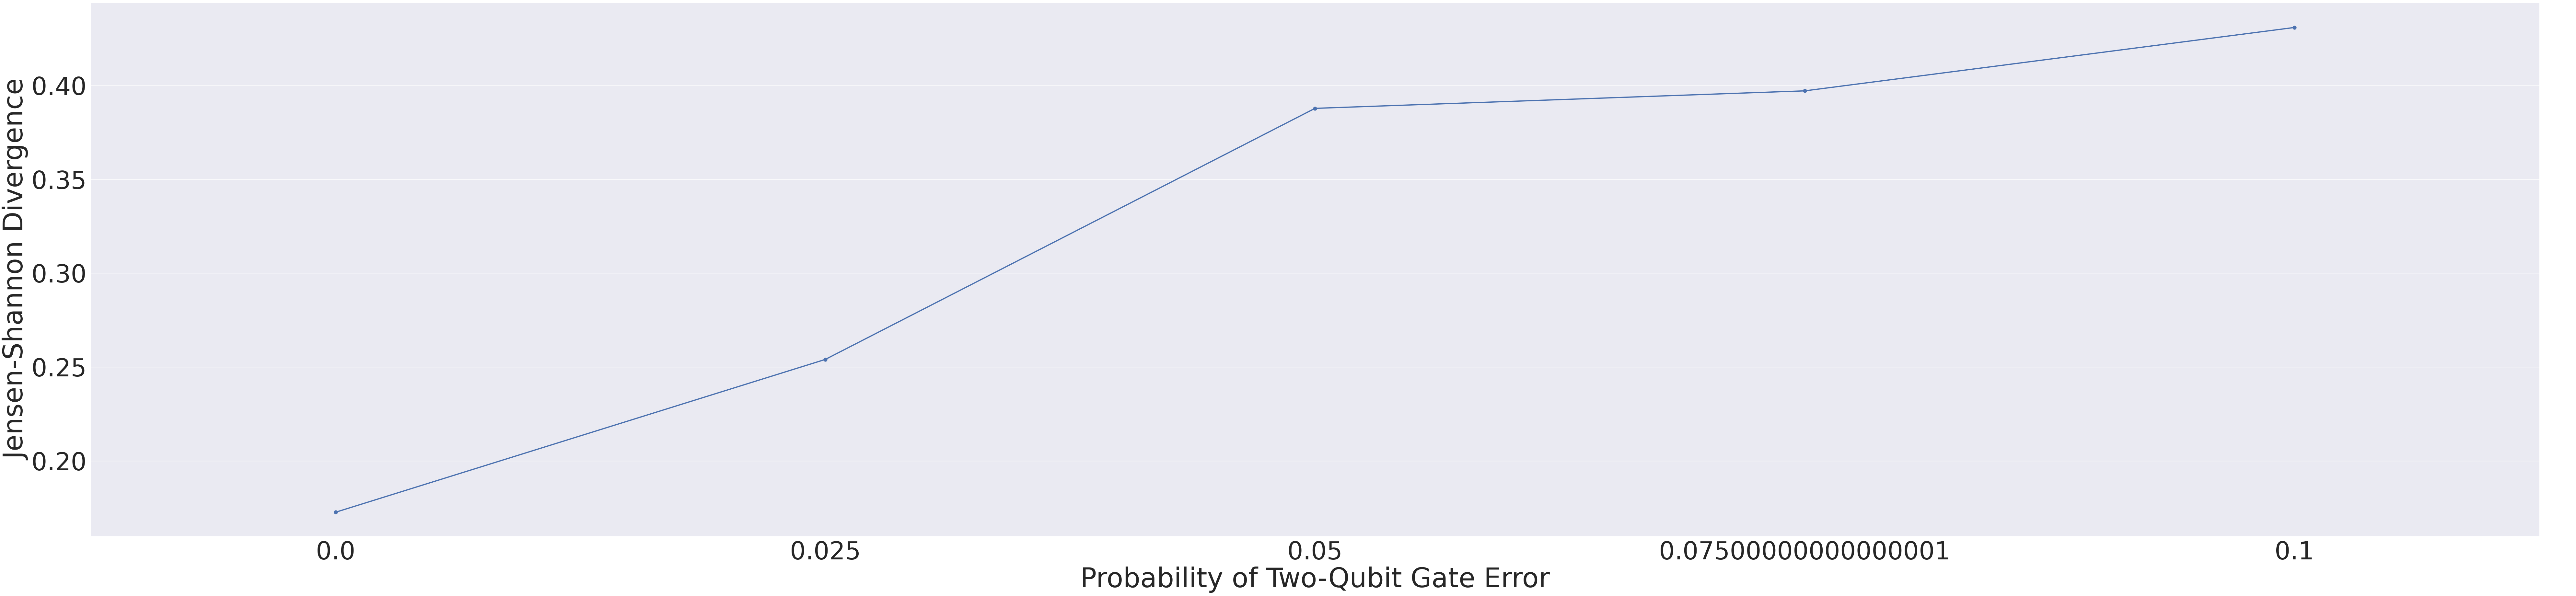

In [79]:
ax = sns.catplot(df, x="P2", y="JSD", kind="point", aspect=4, height=20)
ax.set_xlabels("Probability of Two-Qubit Gate Error")
ax.set_ylabels("Jensen-Shannon Divergence")

## Summary

H-Series provides emulators for end-users to test, verify and optimize the jobs they will eventual submit to the H-Series devices. Two simulation modes exist for H-Series, *state-vector* and *stabilizer*. The simulation type will depend on the end-users' use-case. The noise-model can be disabled, and the a local noiseless emulator is available via `pytket-pecos`. The noise-model in the cloud emulator can be configured and customized by submitting options to the Quantinuum API by constructing `QuantinuumBackend` and using the keyword argument, `options`, or by using the instance method, `process_circuit` (`process_circuits`) with the keyword argument `options`.

A use-case showcases how increasing the `p2` value in the cloud emulator noise-model leads to worse JSD estimates.

<div align="center"> &copy; 2024 by Quantinuum. All Rights Reserved. </div>